In [ ]:
#default_exp vision.augment
#default_cls_lvl 3

# Data augmentation in computer vision

> Transforms to apply data augmentation in Computer Vision

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.vision.core import *
from local.notebook.showdoc import show_doc

In [ ]:
# export
from torch import stack, zeros_like as t0, ones_like as t1
from torch.distributions.bernoulli import Bernoulli

In [ ]:
img = PILImage(PILImage.create(TEST_IMAGE).resize((600,400)))

## RandTransform-

In [ ]:
# export
@docs
class RandTransform(Transform):
    "A transform that randomize its state at each `__call__`, only applied on the training set"
    filt=0
    def __init__(self, encodes=None, decodes=None, randomize=None, p=1.):
        self.p = p
        if randomize is not None: self.randomize=randomize
        super().__init__(encodes, decodes)

    def randomize(self, b): self.do = random.random() < self.p

    def __call__(self, b, filt=None, **kwargs):
        self.randomize(b) #Randomize before calling
        if not getattr(self, 'do', True): return b
        return super().__call__(b, filt=filt, **kwargs)

    _docs = dict(randomize="Randomize the state for input `b`")

In [ ]:
show_doc(RandTransform, title_level=2)

<h2 id="RandTransform" class="doc_header"><code>class</code> <code>RandTransform</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/09_vision_augment.ipynb#RandTransform-" class="source_link" style="float:right">[source]</a></h2>

> <code>RandTransform</code>(**`encodes`**=*`None`*, **`decodes`**=*`None`*, **`randomize`**=*`None`*, **`p`**=*`1.0`*) :: [`Transform`](/data.transforms.html#Transform)

A transform that randomize its state at each `__call__`, only applied on the training set

As for all `Transform` you can pass `encodes` and `decodes` at init or subclass and implement them. You can do the same for the `randomize` method that is called at each `__call__`. Note that to have a consistent state for inputs and targets, a `RandTransform` must be applied at the tuple level. 

By default the randomize behavior is to execute the transform with probability `p` (if subclassing and wanting to tweak that behavior, the attribute `self.do`, if it exists, is looked for to decide if the transform is executed or not).

> Note: A `RandTransform` is only applied to the training set by default, so you have to pass `filt=0` if you are calling it directly and not through a `Datasource`. That behavior can be changed by setting the class variable `filt` of the transform to `None`.

In [ ]:
show_doc(RandTransform.randomize)

<h4 id="RandTransform.randomize" class="doc_header"><code>RandTransform.randomize</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/09_vision_augment.ipynb#RandTransform-" class="source_link" style="float:right">[source]</a></h4>

> <code>RandTransform.randomize</code>(**`b`**)

Randomize the state for input `b`

In [ ]:
def _add1(x): return x+1
dumb_tfm = RandTransform(_add1, p=0.5)
start = 2
for _ in range(10):
    t = dumb_tfm(start, filt=0)
    if dumb_tfm.do: test_eq(t, start+1)
    else:           test_eq(t, start)

In [ ]:
#hide
def _pnt2tensor(pnts, sz):
    t = torch.zeros(*sz)
    for p in pnts: t[p[1],p[0]] = 1.
    return t

def _tensor2pil(t):
    return PILImage(Image.fromarray(t.numpy()))

### PIL transforms

PIL tranforms need to run before `ImageToByteTensor` (that has an order of 10).

In [ ]:
# export
def _minus_axis(x, axis):
    x[...,axis] = -x[...,axis]
    return x

class PILFlip(RandTransform):
    "Randomly flip with probability `p`"
    def __init__(self, p=0.5): self.p = p
    def encodes(self, x:PILImage):    return x.transpose(Image.FLIP_LEFT_RIGHT)
    def encodes(self, x:TensorPoint): return _minus_axis(x, 0)
    def encodes(self, x:TensorBBox):
        bb,lbl = x
        bb = _minus_axis(bb.view(-1,2), 0)
        return (bb.view(-1,4),lbl)

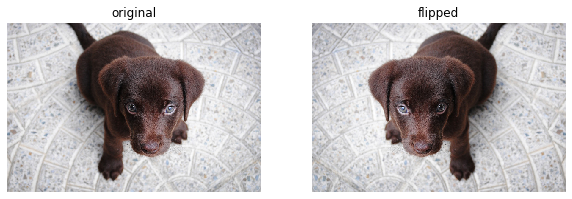

In [ ]:
flip = PILFlip(p=1.)
_,axs = plt.subplots(1,2, figsize=(10,4))
show_image(img, ctx=axs[0], title='original')
show_image(flip(img, filt=0), ctx=axs[1], title='flipped');

In [ ]:
t = _pnt2tensor([[1,0], [2,1]], (3,3))
x = _tensor2pil(t)
y = flip(x, filt=0)
test_eq(tensor(array(y)), _pnt2tensor([[1,0], [0,1]], (3,3)))

pnts = TensorPoint(tensor([[1.,0], [2,1]]) -1)
test_eq(flip(pnts, filt=0), tensor([[1.,0], [0,1]]) -1)


bbox = TensorBBox((tensor([[1.,0., 2.,1]]) -1, ["nothing"]))
test_eq(flip(bbox, filt=0)[0], tensor([[1.,0., 0.,1]]) -1)

In [ ]:
# export
class PILDihedral(RandTransform):
    "Applies any of the eight dihedral transformations with probability `p`"
    def __init__(self, p=0.5, draw=None): self.p,self.draw = p,draw
    def randomize(self, b):
        super().randomize(b)
        if self.draw is None: self.idx = random.randint(0,7)
        else: self.idx = self.draw() if isinstance(self.draw, Callable) else self.draw

    def encodes(self, x:PILImage): return x if self.idx==0 else x.transpose(self.idx-1)
    def encodes(self, x:TensorPoint):
        if self.idx in [1, 3, 4, 7]: x = _minus_axis(x, 0)
        if self.idx in [2, 4, 5, 7]: x = _minus_axis(x, 1)
        if self.idx in [3, 5, 6, 7]: x = x.flip(1)
        return x

    def encodes(self,  x:TensorBBox):
        pnts = self._get_func(self.encodes, TensorPoint)(x[0].view(-1,2)).view(-1,2,2)
        tl,br = pnts.min(dim=1)[0],pnts.max(dim=1)[0]
        return [torch.cat([tl, br], dim=1), x[1]]

By default each of the 8 dihedral transformations (including noop) have the same probability of being picked when the transform is applied. You can customize this behavior by passing your own `draw` function. To force a specific flip, you can also pass an integer between 0 and 7. 

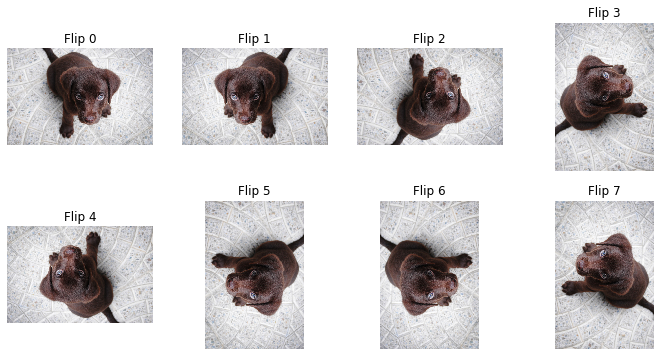

In [ ]:
_,axs = plt.subplots(2,4, figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    dih = PILDihedral(p=1., draw=i)
    show_image(dih(img, filt=0), ctx=ax, title=f'Flip {i}')

In [ ]:
t = _pnt2tensor([[1,0], [2,1]], (3,3))
x = _tensor2pil(t)
for i in range(8):
    dih = PILDihedral(p=1., draw=i)
    y = dih(x, filt=0)
    res = tensor(array(y))
    pnts = TensorPoint(tensor([[1.,0.], [2,1]]) -1)
    a,b = dih(pnts, filt=0), res.nonzero().flip(1).float() -1
    assert equals(a,b) or equals(a,b.flip(0))

## Resize with crop, pad or squish

In [ ]:
# export
def clip_remove_empty(bbox, label):
    "Clip bounding boxes with image border and label background the empty ones."
    bbox = torch.clamp(bbox, -1, 1)
    empty = ((bbox[...,2] - bbox[...,0])*(bbox[...,3] - bbox[...,1]) < 0.)
    if isinstance(label, torch.Tensor): label[empty] = 0
    else: label = [0 if m else l for l,m in zip(label,empty)]
    return (bbox, label)

In [ ]:
bb = torch.tensor([[-2,-0.5,0.5,1.5], [-0.5,-0.5,0.5,0.5], [1,0.5,0.5,0.75]])
bb,lbl = clip_remove_empty(bb, ['too big', 'normal', 'empty'])
test_eq(bb, torch.tensor([[-1,-0.5,0.5,1.], [-0.5,-0.5,0.5,0.5], [1,0.5,0.5,0.75]]))
test_eq(lbl, ['too big', 'normal', 0])

In [ ]:
# export
from torchvision.transforms.functional import pad as tvpad

In [ ]:
# export
mk_class('PadMode', **{o:o.lower() for o in ['Zeros', 'Border', 'Reflection']},
         doc="All possible padding mode as attributes to get tab-completion and typo-proofing")

In [ ]:
show_doc(PadMode, title_level=3)

<h3 id="PadMode" class="doc_header"><code>class</code> <code>PadMode</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>PadMode</code>(**\*`args`**, **\*\*`kwargs`**)

All possible padding mode as attributes to get tab-completion and typo-proofing

In [ ]:
# export
class CropPad(Transform):
    "Center crop or pad an image to `size`"
    order = 5
    _pad_modes = {'zeros': 'constant', 'border': 'edge', 'reflection': 'reflect'}
    def __init__(self, size, pad_mode=PadMode.Zeros, **kwargs):
        super().__init__(**kwargs)
        if isinstance(size,int): size=(size,size)
        self.size,self.pad_mode = (size[1],size[0]),self._pad_modes[pad_mode]

    def randomize(self, b, filt):
        self.orig_size = (b[0] if isinstance(b, tuple) else b).size
        self.tl = ((self.orig_size[0]-self.cp_size[0])//2, (self.orig_size[1]-self.cp_size[1])//2)

    def __call__(self, b, filt=None, size=None, **kwargs):
        self.cp_size = ifnone(size,self.size)
        self.randomize(b, filt) #Randomize before calling
        return super().__call__(b, filt=filt, **kwargs)

    def _crop_pad(self, x, mode=Image.BILINEAR):
        if self.tl[0] > 0 or self.tl[1] > 0:
            cw,ch = int(max(self.tl[0],0)),int(max(self.tl[1],0))
            fw, fh = int(min(cw+self.cp_size[0], self.orig_size[0])),int(min(ch+self.cp_size[1], self.orig_size[1]))
            x = x.crop((cw, ch, fw, fh))
        if self.tl[0] < 0 or self.tl[1] < 0:
            pw,ph = int(max(-self.tl[0],0)),int(max(-self.tl[1],0))
            fw, fh = int(max(self.cp_size[0]-self.orig_size[0]-pw,0)),int(max(self.cp_size[1]-self.orig_size[1]-ph,0))
            x = tvpad(x, (pw, ph, fw, fh), padding_mode=self.pad_mode)
        if getattr(self, 'final_sz', False): x = x.resize(self.final_sz, mode)
        return x

    def encodes(self, x:PILImage): return self._crop_pad(x, getattr(self, 'mode', Image.BILINEAR))
    def encodes(self, x:PILMask):  return self._crop_pad(x, getattr(self, 'mode_mask', Image.NEAREST))

    def encodes(self, x:TensorPoint):
        old_sz,new_sz,tl = map(lambda o: tensor(o).float(), (self.orig_size,self.cp_size,self.tl))
        return (x + 1) * old_sz/new_sz - tl * 2/new_sz - 1

    def encodes(self, x:TensorBBox):
        bbox,label = x
        bbox = self.encodes(TensorPoint(bbox.view(-1,2))).view(-1,4)
        return clip_remove_empty(bbox, label)

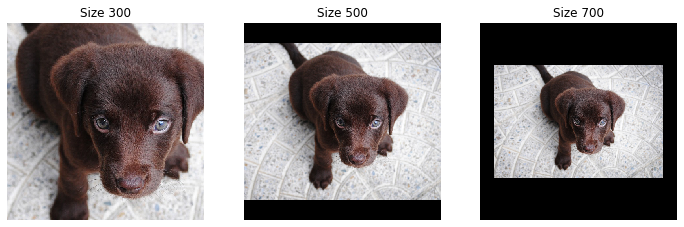

In [ ]:
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,sz in zip(axs.flatten(), [300, 500, 700]):
    pad = CropPad(sz)
    show_image(pad(img), ctx=ax, title=f'Size {sz}');

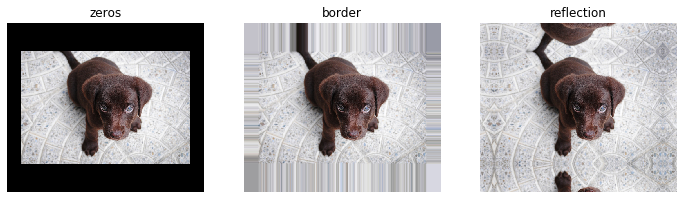

In [ ]:
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,mode in zip(axs.flatten(), [PadMode.Zeros, PadMode.Border, PadMode.Reflection]):
    pad = CropPad((600,700), pad_mode=mode)
    show_image(pad(img), ctx=ax, title=mode);

In [ ]:
#hide
t = torch.empty(20,16).uniform_(0,1)
x = _tensor2pil(t)
crop = CropPad(10)
y = crop(x)
test_eq(y.size, (10,10))
test_eq(tensor(array(y)), t[5:15,3:13])

crop.as_item=False
pts = TensorPoint(torch.tensor([[-1,-1], [-0.5,-0.5], [0.,0.]]))
y,p1 = crop((x,pts))
test_eq(p1, torch.tensor([[-1.6, -2], [-0.8,-1], [0,0]]))

In [ ]:
#hide
#Padding test
t = torch.empty(10,8).uniform_(0,1)
x = _tensor2pil(t)
crop = CropPad(12)
y = crop(x)
test_eq(y.size, (12,12))
test_eq(tensor(array(y))[1:11,2:10], t)

crop.as_item=False
pts = TensorPoint(torch.tensor([[-1,-1], [-0.5,-0.5], [0.,0.]]))
y,p1 = crop((x,pts))
test_close(p1, torch.tensor([[-2/3, -5/6], [-1/3,-5/12], [0,0]]))

## RandomCrop -

In [ ]:
# export
class RandomCrop(CropPad):
    "Randomly crop an image to `size`"
    def __init__(self, size): super().__init__(size)

    def randomize(self, b, filt):
        w,h = (b[0] if isinstance(b, tuple) else b).size
        self.orig_size = (w,h)
        if filt: self.tl = ((w-self.cp_size[0])//2, (h-self.cp_size[1])//2)
        else: self.tl = (random.randint(0,w-self.cp_size[0]), random.randint(0,h-self.cp_size[1]))

On the validation set, we take a center crop.

In [ ]:
#hide
t = torch.empty(20,16).uniform_(0,1)
x = _tensor2pil(t)
crop = RandomCrop(10)
y = crop(x, filt=0)
test_eq(y.size, (10,10))
test_eq(tensor(array(y)), t[crop.tl[1]:crop.tl[1]+10,crop.tl[0]:crop.tl[0]+10])

crop.as_item=False
pts = TensorPoint(torch.tensor([[-1,-1], [-0.5,-0.5], [0.,0.]]))
y,p1 = crop((x,pts), filt=0)
test_eq(p1, (pts+1) * tensor([1.6,2.]) - tensor(crop.tl).float()/5 - 1)

In [ ]:
# export
mk_class('ResizeMethod', **{o:o.lower() for o in ['Squish', 'Crop', 'Pad']},
         doc="All possible resize method as attributes to get tab-completion and typo-proofing")

In [ ]:
show_doc(ResizeMethod, title_level=3)

<h3 id="ResizeMethod" class="doc_header"><code>class</code> <code>ResizeMethod</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>ResizeMethod</code>(**\*`args`**, **\*\*`kwargs`**)

All possible resize method as attributes to get tab-completion and typo-proofing

In [ ]:
test_eq(ResizeMethod.Squish, 'squish')

## Resize -

In [ ]:
# export
class Resize(CropPad):
    order=10
    "Resize image to `size` using `method`"
    def __init__(self, size, method=ResizeMethod.Squish, pad_mode=PadMode.Reflection,
                 resamples=(Image.BILINEAR, Image.NEAREST), **kwargs):
        super().__init__(size, pad_mode=pad_mode, **kwargs)
        (self.mode,self.mode_mask),self.method = resamples,method

    def randomize(self, b, filt):
        self.final_sz = self.cp_size
        w,h = (b[0] if isinstance(b, tuple) else b).size
        self.orig_size = (w,h)
        if self.method==ResizeMethod.Squish:
            self.tl,self.cp_size = (0,0),(w,h)
            return

        op = (operator.lt,operator.gt)[self.method==ResizeMethod.Pad]
        m = w/self.final_sz[0] if op(w/self.final_sz[0],h/self.final_sz[1]) else h/self.final_sz[1]
        self.cp_size = (m*self.final_sz[0],m*self.final_sz[1])
        if self.method==ResizeMethod.Pad or filt: self.tl = ((w-self.cp_size[0])//2, (h-self.cp_size[1])//2)
        else: self.tl = (random.randint(0,w-self.cp_size[0]), random.randint(0,h-self.cp_size[1]))

`size` can be an integer (in which case images will be resized to a square) or a tuple. Depending on the `method`:
- we squish any rectangle to `size`
- we resize so that the shorter dimension is a match an use padding with `pad_mode` 
- we resize so that the larger dimension is match and crop (randomly on the training set, center crop for the validation set)

When doing the resize, we use `resamples[0]` for images and `resamples[1]` for segmentation masks.

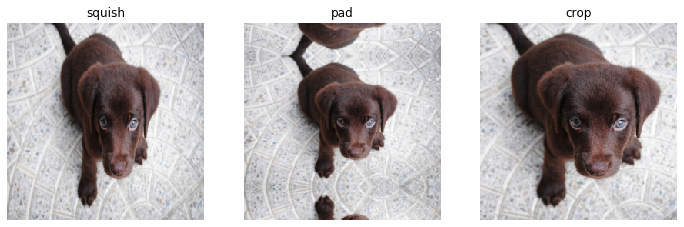

In [ ]:
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,method in zip(axs.flatten(), [ResizeMethod.Squish, ResizeMethod.Pad, ResizeMethod.Crop]):
    rsz = Resize(256, method=method)
    show_image(rsz(img, filt=1), ctx=ax, title=method);

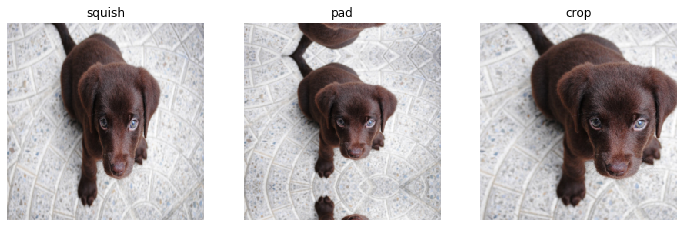

In [ ]:
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,method in zip(axs.flatten(), [ResizeMethod.Squish, ResizeMethod.Pad, ResizeMethod.Crop]):
    rsz = Resize(256, method=method)
    show_image(rsz(img, filt=0), ctx=ax, title=method);

In [ ]:
#TODO test

## RandomResizedCrop -

In [ ]:
# export
class RandomResizedCrop(CropPad):
    "Picks a random scaled crop of an image and resize it to `size`"
    def __init__(self, size, min_scale=0.08, ratio=(3/4, 4/3), resamples=(Image.BILINEAR, Image.NEAREST), **kwargs):
        super().__init__(size, **kwargs)
        self.min_scale,self.ratio = min_scale,ratio
        self.mode,self.mode_mask = resamples

    def randomize(self, b, filt):
        self.final_sz = self.cp_size
        w,h = (b[0] if isinstance(b, tuple) else b).size
        self.orig_size = w,h
        for attempt in range(10):
            if filt: break
            area = random.uniform(self.min_scale,1.) * w * h
            ratio = math.exp(random.uniform(math.log(self.ratio[0]), math.log(self.ratio[1])))
            nw = int(round(math.sqrt(area * ratio)))
            nh = int(round(math.sqrt(area / ratio)))
            if nw <= w and nh <= h:
                self.cp_size = (nw,nh)
                self.tl = random.randint(0,w-nw), random.randint(0,h - nh)
                return
        if   w/h < self.ratio[0]: self.cp_size = (w, int(w/self.ratio[0]))
        elif w/h > self.ratio[1]: self.cp_size = (int(h*self.ratio[1]), h)
        else:                     self.cp_size = (w, h)
        self.tl = ((w-self.cp_size[0])//2, (h-self.cp_size[1])//2)

The crop picked as a random scale in range `(min_scale,1)` and `ratio` in the range passed, then the resize is done with `resamples[0]` for images and `resamples[1]` for segmentation masks. On the validation set, we center crop the image if it's ratio isn't in the range (to the minmum or maximum value) then resize.

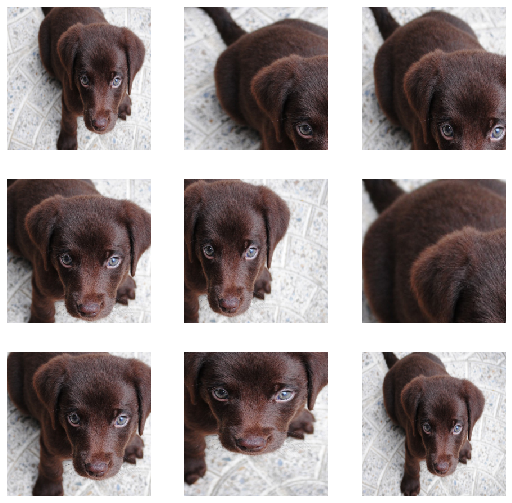

In [ ]:
crop = RandomResizedCrop(256)
_,axs = plt.subplots(3,3,figsize=(9,9))
for ax in axs.flatten():
    cropped = crop(img)
    show_image(cropped, ctx=ax);

In [ ]:
#TODO: test

## Affine and coord tfm on the GPU

In [ ]:
def _batch_ex(bs):
    timg = tensor(array(img)).permute(2,0,1).float()/255.
    return TensorImage(timg[None].expand(bs, *timg.shape))

In [ ]:
# export
class AffineCoordTfm(RandTransform):
    "Combine and apply affine and coord transforms"
    order = 30
    def __init__(self, aff_fs=None, coord_fs=None, size=None, mode='bilinear', pad_mode=PadMode.Reflection):
        self.aff_fs,self.coord_fs,self.mode,self.pad_mode = L(aff_fs),L(coord_fs),mode,pad_mode
        self.cp_size = None if size is None else (size,size) if isinstance(size, int) else tuple(size)

    def randomize(self, b):
        if isinstance(b, tuple): b = b[0]
        self.do,self.mat = True,self._get_affine_mat(b)[:,:2]
        for t in self.coord_fs: t.randomize(b)

    def compose(self, tfm):
        "Compose `self` with another `AffineCoordTfm` to only do the interpolation step once"
        self.aff_fs   += tfm.aff_fs
        self.coord_fs += tfm.coord_fs

    def _get_affine_mat(self, x):
        aff_m = torch.eye(3, dtype=x.dtype, device=x.device)
        aff_m = aff_m.unsqueeze(0).expand(x.size(0), 3, 3)
        ms = [f(x) for f in self.aff_fs]
        ms = [m for m in ms if m is not None]
        for m in ms: aff_m = aff_m @ m
        return aff_m

    def encodes(self, x:TensorImage):
        if self.mat is None and len(self.coord_tfms)==0: return x
        bs = x.size(0)
        size = tuple(x.shape[-2:]) if self.cp_size is None else size
        size = (bs,x.size(1)) + size
        coords = F.affine_grid(self.mat, size)
        coords = compose_tfms(coords, self.coord_fs)
        return F.grid_sample(x, coords, mode=self.mode, padding_mode=self.pad_mode)

    def encodes(self, x:TensorMask):
        self.mode,old_mode = 'nearest',self.mode
        res = self.encodes(TensorImage(x.float()[:,None])).long()[:,0]
        self.mode = old_mode
        return res

    def encodes(self, x:TensorPoint):
        x = compose_tfms(x, self.coord_fs, reverse=True, invert=True)
        return (x - self.mat[:,:,2].unsqueeze(1)) @ torch.inverse(self.mat[:,:,:2].transpose(1,2))

    def encodes(self, x:TensorBBox):
        bbox,label = x
        bs,n = bbox.shape[:2]
        pnts = stack([bbox[...,:2], stack([bbox[...,0],bbox[...,3]],dim=2),
                      stack([bbox[...,2],bbox[...,1]],dim=2), bbox[...,2:]], dim=2)
        pnts = self.encodes(TensorPoint(pnts.view(bs, 4*n, 2)))
        pnts = pnts.view(bs, n, 4, 2)
        tl,dr = pnts.min(dim=2)[0],pnts.max(dim=2)[0]
        return clip_remove_empty(torch.cat([tl, dr], dim=2), label)

Multipliy all the matrices returned by `aff_fs` before doing the corresponding affine transformation on a basic grid corresponding to `size`, then applies all `coord_fs` on the resulting flow of coordinates before finally doing an interpolation with `mode` and `pad_mode`.

In [ ]:
show_doc(AffineCoordTfm.compose)

<h4 id="AffineCoordTfm.compose" class="doc_header"><code>AffineCoordTfm.compose</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/09_vision_augment.ipynb#Affine-and-coord-tfm-on-the-GPU" class="source_link" style="float:right">[source]</a></h4>

> <code>AffineCoordTfm.compose</code>(**`tfm`**)

Compose `self` with another [`AffineCoordTfm`](/vision.augment.html#AffineCoordTfm) to only do the interpolation step once

In [ ]:
# export
def affine_mat(*ms):
    "Restructure length-6 vector `ms` into an affine matrix with 0,0,1 in the last line"
    return stack([stack([ms[0], ms[1], ms[2]], dim=1),
                  stack([ms[3], ms[4], ms[5]], dim=1),
                  stack([t0(ms[0]), t0(ms[0]), t1(ms[0])], dim=1)], dim=1)

In [ ]:
# export
def mask_tensor(x, p=0.5, neutral=0.):
    "Mask elements of `x` with `neutral` with probability `1-p`"
    if p==1.: return x
    if neutral != 0: x.add_(-neutral)
    mask = x.new_empty(*x.size()).bernoulli_(p)
    x.mul_(mask)
    return x.add_(neutral) if neutral != 0 else x

In [ ]:
# export
def flip_mat(x, p=0.5):
    "Return a random flip matrix"
    mask = mask_tensor(-x.new_ones(x.size(0)), p=p, neutral=1.)
    return affine_mat(mask,     t0(mask), t0(mask),
                      t0(mask), t1(mask), t0(mask))

In [ ]:
x = flip_mat(torch.randn(100,4,3))
test_eq(set(x[:,0,0].numpy()), {-1,1}) #might fail with probability 2*2**(-100) (picked only 1s or -1s)

In [ ]:
# export
def Flip(p=0.5, size=None, mode='bilinear', pad_mode=PadMode.Reflection):
    "Randomly flip a batch of images with a probability `p`"
    return AffineCoordTfm(aff_fs=partial(flip_mat, p=p), size=size, mode=mode, pad_mode=pad_mode)

In [ ]:
flip = Flip(p=1.)
t = _pnt2tensor([[1,0], [2,1]], (3,3))
y = flip(TensorImage(t[None,None]), filt=0)
test_eq(y, _pnt2tensor([[1,0], [0,1]], (3,3))[None,None])

pnts = TensorPoint((tensor([[1.,0.], [2,1]]) -1)[None])
test_eq(flip(pnts, filt=0), tensor([[[1.,0.], [0,1]]]) -1)

bbox = TensorBBox(((tensor([[1.,0., 2.,1]]) -1)[None], tensor([0.])[None]))
test_eq(flip(bbox, filt=0)[0], tensor([[[0.,0., 1.,1.]]]) -1)

In [ ]:
# export
def _draw_mask(x, def_draw, draw=None, p=0.5, neutral=0.):
    if draw is None: draw=def_draw
    if isinstance(draw, Callable):
        res = x.new_empty(x.size(0))
        for i in range_of(res): res[i] = draw()
    elif is_listy(draw):
        test_eq(len(draw), x.size(0))
        res = tensor(draw, dtype=x.dtype, device=x.device)
    else: res = x.new_zeros(x.size(0)) + draw
    return mask_tensor(res, p=p, neutral=neutral)

In [ ]:
x = torch.zeros(5,2,3)
def_draw = lambda: random.randint(0,7)
t = _draw_mask(x, def_draw)
assert (0. <= t).all() and (t <= 7).all() 
t = _draw_mask(x, def_draw, 1)
assert (0. <= t).all() and (t <= 1).all() 
test_eq(_draw_mask(x, def_draw, 1, p=1), tensor([1.,1,1,1,1]))
test_eq(_draw_mask(x, def_draw, [0,1,2,3,4], p=1), tensor([0.,1,2,3,4]))

In [ ]:
# export
def dihedral_mat(x, p=0.5, draw=None):
    "Return a random dihedral matrix"
    def _def_draw(): return random.randint(0,7)
    idx = _draw_mask(x, _def_draw, draw=draw, p=p).long()
    xs = tensor([1,-1,1,-1,-1,1,1,-1], device=x.device).gather(0, idx)
    ys = tensor([1,1,-1,1,-1,-1,1,-1], device=x.device).gather(0, idx)
    m0 = tensor([1,1,1,0,1,0,0,0], device=x.device).gather(0, idx)
    m1 = tensor([0,0,0,1,0,1,1,1], device=x.device).gather(0, idx)
    return affine_mat(xs*m0,  xs*m1,  t0(xs),
                      ys*m1,  ys*m0,  t0(xs)).float()
    mask = mask_tensor(-x.new_ones(x.size(0)), p=p, neutral=1.)

In [ ]:
# export
def Dihedral(p=0.5, draw=None, size=None, mode='bilinear', pad_mode=PadMode.Reflection):
    "Apply a random dihedral transformation to a batch of images with a probability `p`"
    return AffineCoordTfm(aff_fs=partial(dihedral_mat, p=p, draw=draw), size=size, mode=mode, pad_mode=pad_mode)

`draw` can be specified if you want to customize which flip is picked when the transform is applied (default is a random number between 0 and 7). It can be an integer between 0 and 7, a list of such integers (which then should have a length equal to the size of the batch) or a callable that returns an integer between 0 and 7.

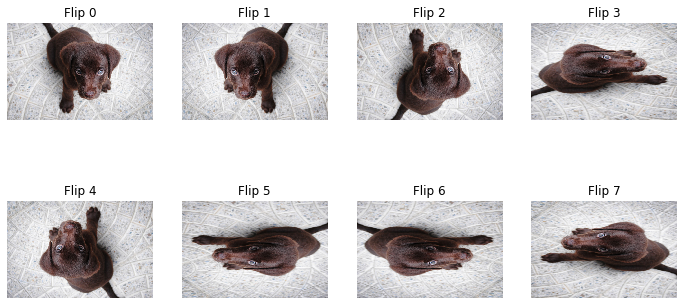

In [ ]:
t = _batch_ex(8)
dih = Dihedral(p=1., draw=list(range(8)))
y = dih(t, filt=0)
_,axs = plt.subplots(2,4, figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax, title=f'Flip {i}')

In [ ]:
#hide
#Test behavior with iamges and points is consistent
t = _pnt2tensor([[1,0], [2,1], [2,2]], (3,3))[None,None].expand(8,1,3,3)
dih = Dihedral(p=1., draw=list(range(8)))
y = dih(TensorImage(t), filt=0)
res = y.nonzero()
pnts = tensor([[[1.,0.], [2,1], [2,2]]]) -1
z = dih(TensorPoint(pnts.expand(8,3,2)), filt=0)+1
for i in range(8):
    vals = {(t[0] + t[1]*3).item() for t in res[i*3:(i+1)*3][:,2:].flip(1)}
    vals1 = {(t[0] + t[1]*3).item() for t in z[i]}
    test_eq(vals, vals1)
    
#Test order is the same as PILDihedral
tt = _pnt2tensor([[1,0], [2,1], [2,2]], (3,3))
x = _tensor2pil(tt)
for i in range(8):
    dih1 = PILDihedral(p=1., draw=i)
    y1 = dih1(x, filt=0)
    test_eq(y[i,0], tensor(array(y1)))

In [ ]:
# export
def rotate_mat(x, max_deg=10, p=0.5, draw=None):
    "Return a random rotation matrix with `max_deg` and `p`"
    def _def_draw(): return random.uniform(-max_deg,max_deg)
    thetas = _draw_mask(x, _def_draw, draw=draw, p=p) * math.pi/180
    return affine_mat(thetas.cos(), thetas.sin(), t0(thetas),
                     -thetas.sin(), thetas.cos(), t0(thetas))

In [ ]:
# export
def Rotate(max_deg=10, p=0.5, draw=None, size=None, mode='bilinear', pad_mode=PadMode.Reflection):
    "Apply a random rotation of at most `max_deg` with probability `p` to a batch of images"
    return AffineCoordTfm(partial(rotate_mat, max_deg=max_deg, p=p, draw=draw),
                          size=size, mode=mode, pad_mode=pad_mode)

`draw` can be specified if you want to customize which angle is picked when the transform is applied (default is a random flaot between `-max_deg` and `max_deg`). It can be a float, a list of floats (which then should have a length equal to the size of the batch) or a callable that returns a float.

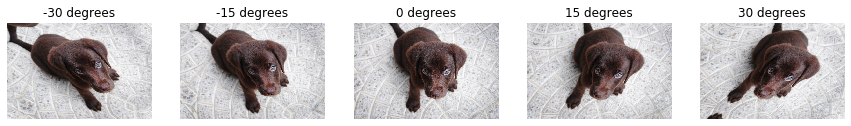

In [ ]:
thetas = [-30,-15,0,15,30]
rot = Rotate(draw=thetas, p=1.)
y = rot(_batch_ex(5), filt=0)
_,axs = plt.subplots(1,5, figsize=(15,3))
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax, title=f'{thetas[i]} degrees')

In [ ]:
# export
def zoom_mat(x, max_zoom=1.1, p=0.5, draw=None, draw_x=None, draw_y=None):
    "Return a random zoom matrix with `max_zoom` and `p`"
    def _def_draw():     return random.uniform(1., max_zoom)
    def _def_draw_ctr(): return random.uniform(0.,1.)
    s = 1/_draw_mask(x, _def_draw, draw=draw, p=p, neutral=1.)
    col_pct = _draw_mask(x, _def_draw_ctr, draw=draw_x, p=1.)
    row_pct = _draw_mask(x, _def_draw_ctr, draw=draw_y, p=1.)
    col_c = (1-s) * (2*col_pct - 1)
    row_c = (1-s) * (2*row_pct - 1)
    return affine_mat(s,     t0(s), col_c,
                      t0(s), s,     row_c)

In [ ]:
# export
def Zoom(max_zoom=1.1, p=0.5, draw=None, draw_x=None, draw_y=None, size=None, mode='bilinear',
         pad_mode=PadMode.Reflection):
    "Apply a random zoom of at most `max_zoom` with probability `p` to a batch of images"
    return AffineCoordTfm(partial(zoom_mat, max_zoom=max_zoom, p=p, draw=draw, draw_x=draw_x, draw_y=draw_y),
                          size=size, mode=mode, pad_mode=pad_mode)

`draw`, `draw_x` and `draw_y` can be specified if you want to customize which scale and center are picked when the transform is applied (default is a random float between 1 and `max_zoom` for the first, between 0 and 1 for the last two). Each can be a float, a list of floats (which then should have a length equal to the size of the batch) or a callbale that returns a float.

`draw_x` and `draw_y` are expected to be the position of the center in pct, 0 meaning the most left/top possible and 1 meaning the most right/bottom possible.

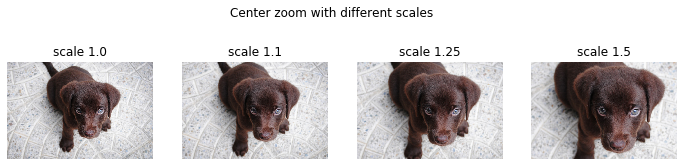

In [ ]:
scales = [1., 1.1, 1.25, 1.5]
zoom = Zoom(draw=scales, p=1., draw_x=0.5, draw_y=0.5)
y = zoom(_batch_ex(4), filt=0)
fig,axs = plt.subplots(1,4, figsize=(12,3))
fig.suptitle('Center zoom with different scales')
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax, title=f'scale {scales[i]}')

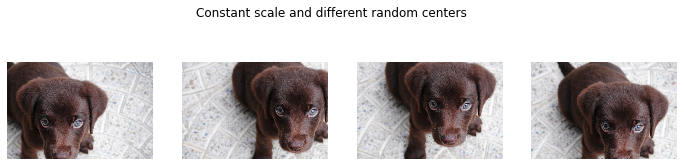

In [ ]:
zoom = Zoom(draw=1.5, p=1.)
y = zoom(_batch_ex(4), filt=0)
fig,axs = plt.subplots(1,4, figsize=(12,3))
fig.suptitle('Constant scale and different random centers')
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax)

### Warping

In [ ]:
# export
def find_coeffs(p1, p2):
    "Find coefficients for warp tfm from `p1` to `p2`"
    m = []
    p = p1[:,0,0]
    #The equations we'll need to solve.
    for i in range(p1.shape[1]):
        m.append(stack([p2[:,i,0], p2[:,i,1], t1(p), t0(p), t0(p), t0(p), -p1[:,i,0]*p2[:,i,0], -p1[:,i,0]*p2[:,i,1]]))
        m.append(stack([t0(p), t0(p), t0(p), p2[:,i,0], p2[:,i,1], t1(p), -p1[:,i,1]*p2[:,i,0], -p1[:,i,1]*p2[:,i,1]]))
    #The 8 scalars we seek are solution of AX = B
    A = stack(m).permute(2, 0, 1)
    B = p1.view(p1.shape[0], 8, 1)
    return torch.solve(B,A)[0]

In [ ]:
# export
def apply_perspective(coords, coeffs):
    "Apply perspective tranfom on `coords` with `coeffs`"
    sz = coords.shape
    coords = coords.view(sz[0], -1, 2)
    coeffs = torch.cat([coeffs, t1(coeffs[:,:1])], dim=1).view(coeffs.shape[0], 3,3)
    coords = coords @ coeffs[...,:2].transpose(1,2) + coeffs[...,2].unsqueeze(1)
    coords.div_(coords[...,2].unsqueeze(-1))
    return coords[...,:2].view(*sz)

In [ ]:
# export
class _WarpCoord():
    def __init__(self, magnitude=0.2, p=0.5, draw_x=None, draw_y=None):
        self.coeffs,self.magnitude,self.p,self.draw_x,self.draw_y = None,magnitude,p,draw_x,draw_y

    def _def_draw(self): return random.uniform(-self.magnitude, self.magnitude)
    def randomize(self, x):
        x_t = _draw_mask(x, self._def_draw, self.draw_x, p=self.p)
        y_t = _draw_mask(x, self._def_draw, self.draw_y, p=self.p)
        orig_pts = torch.tensor([[-1,-1], [-1,1], [1,-1], [1,1]], dtype=x.dtype, device=x.device)
        self.orig_pts = orig_pts.unsqueeze(0).expand(x.size(0),4,2)
        targ_pts = stack([stack([-1-y_t, -1-x_t]), stack([-1+y_t, 1+x_t]),
                          stack([ 1+y_t, -1+x_t]), stack([ 1-y_t, 1-x_t])])
        self.targ_pts = targ_pts.permute(2,0,1)

    def __call__(self, x, invert=False):
        coeffs = find_coeffs(self.targ_pts, self.orig_pts) if invert else find_coeffs(self.orig_pts, self.targ_pts)
        return apply_perspective(x, coeffs)

In [ ]:
# export
def Warp(magnitude=0.2, p=0.5, draw_x=None, draw_y=None,size=None, mode='bilinear', pad_mode=PadMode.Reflection):
    "Apply perspective warping with `magnitude` and `p` on a batch of matrices"
    return AffineCoordTfm(coord_fs=_WarpCoord(magnitude=magnitude, p=p, draw_x=draw_x, draw_y=draw_y),
                          size=size, mode=mode, pad_mode=pad_mode)

`draw_x` and `draw_y` can be specified if you want to customize the magnitudes that are picked when the transform is applied (default is a random float between `-magnitude` and `magnitude`. Each can be a float, a list of floats (which then should have a length equal to the size of the batch) or a callable that returns a float.

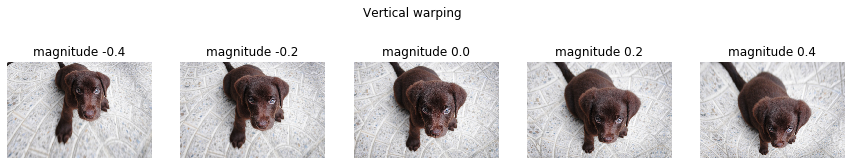

In [ ]:
scales = [-0.4, -0.2, 0., 0.2, 0.4]
warp = Warp(p=1., draw_y=scales, draw_x=0.)
y = warp(_batch_ex(5), filt=0)
fig,axs = plt.subplots(1,5, figsize=(15,3))
fig.suptitle('Vertical warping')
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax, title=f'magnitude {scales[i]}')

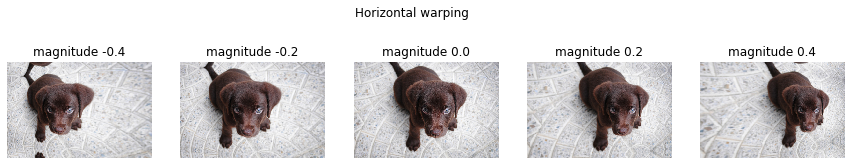

In [ ]:
scales = [-0.4, -0.2, 0., 0.2, 0.4]
warp = Warp(p=1., draw_x=scales, draw_y=0.)
y = warp(_batch_ex(5), filt=0)
fig,axs = plt.subplots(1,5, figsize=(15,3))
fig.suptitle('Horizontal warping')
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax, title=f'magnitude {scales[i]}')

In [ ]:
#hide
x1 = tensor([[1.,0.,0.,0.,1.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.]])
x2 = tensor([[0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [1.,0.,0.,0.,1.]])
x3 = tensor([[1.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [1.,0.,0.,0.,0.]])
x4 = tensor([[0.,0.,0.,0.,1.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,1.]])
warp = Warp(p=1., draw_x=[0.,0,-0.5,0.5], draw_y=[-0.5,0.5,0.,0.])
y = warp(TensorImage(stack([x1,x2,x3,x4])[:,None]), filt=0)
test_eq(y[0,0], tensor([[0.,1.,0.,1.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.]]))
test_eq(y[1,0], tensor([[0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [0.,1.,0.,1.,0.]]))
test_eq(y[2,0], tensor([[0.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,0.]]))
test_eq(y[3,0], tensor([[0.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,0.]]))

In [ ]:
#hide
x = torch.tensor([[[-1.,-1], [1,-1]], [[-1,1],[1,1]], [[-1,-1], [-1,1]], [[1,-1], [1,1]]])
y = warp(TensorPoint(x), filt=0)
test_eq(y, torch.tensor([[[-0.5,-1], [0.5,-1]], [[-0.5,1],[0.5,1]], [[-1,-0.5], [-1,0.5]], [[1,-0.5], [1,0.5]]]))

## Lighting transforms

In [ ]:
# export
def logit(x):
    "Logit of `x`, clamped to avoid inf."
    x = x.clamp(1e-7, 1-1e-7)
    return -(1/x-1).log()

In [ ]:
# export
class LightingTfm(RandTransform):
    "Apply `fs` to the logits"
    order = 40
    def __init__(self, fs): self.fs=L(fs)
    def randomize(self, b):
        self.do = True
        if isinstance(b, tuple): b = b[0]
        for t in self.fs: t.randomize(b)

    def compose(self, tfm):
        "Compose `self` with another `LightingTransform`"
        self.fs += tfm.fs

    def encodes(self,x:TensorImage): return torch.sigmoid(compose_tfms(logit(x), self.fs))

In [ ]:
# export
class _BrightnessLogit():
    def __init__(self, max_lighting=0.2, p=0.75, draw=None):
        self.max_lighting,self.p,self.draw = max_lighting,p,draw

    def _def_draw(self): return random.uniform(0.5*(1-self.max_lighting), 0.5*(1+self.max_lighting))

    def randomize(self, x):
        self.change = _draw_mask(x, self._def_draw, draw=self.draw, p=self.p, neutral=0.5)

    def __call__(self, x): return x.add_(logit(self.change[:,None,None,None]))

In [ ]:
# export
def Brightness(max_lighting=0.2, p=0.75, draw=None):
    "Apply change in brightness of `max_lighting` to batch of images with probability `p`."
    return LightingTfm(_BrightnessLogit(max_lighting, p, draw))

`draw` can be specified if you want to customize the magnitude that is picked when the transform is applied (default is a random float between `-0.5*(1-max_lighting)` and `0.5*(1+max_lighting)`. Each can be a float, a list of floats (which then should have a length equal to the size of the batch) or a callable that returns a float.

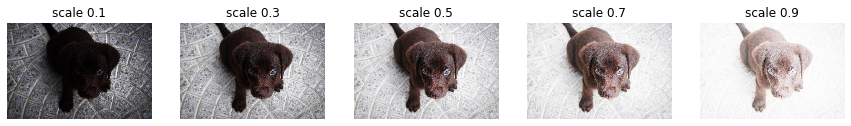

In [ ]:
scales = [0.1, 0.3, 0.5, 0.7, 0.9]
bright = Brightness(p=1., draw=scales)
y = bright(_batch_ex(5), filt=0)
fig,axs = plt.subplots(1,5, figsize=(15,3))
for i,ax in enumerate(axs.flatten()):
    show_image(y[i], ctx=ax, title=f'scale {scales[i]}')

In [ ]:
#hide
x = torch.randn(5, 3, 4, 4)
y = bright(TensorImage(x), filt=0)
y1 = torch.sigmoid(logit(x) + logit(tensor(scales))[:,None,None,None])
test_close(y, y1)

test_eq(bright(TensorMask(x), filt=0), x)
test_eq(bright(TensorPoint(x), filt=0), x)
test_eq(bright(TensorBBox((x,x)), filt=0), (x,x))

In [ ]:
# export
class _ContrastLogit():
    def __init__(self, max_lighting=0.2, p=0.75, draw=None):
        self.max_lighting,self.p,self.draw = max_lighting,p,draw

    def _def_draw(self):
        return math.exp(random.uniform(math.log(1-self.max_lighting), -math.log(1-self.max_lighting)))

    def randomize(self, x):
        self.change = _draw_mask(x, self._def_draw, draw=self.draw, p=self.p, neutral=1.)

    def __call__(self, x): return x.mul_(self.change[:,None,None,None])

In [ ]:
# export
def Contrast(max_lighting=0.2, p=0.75, draw=None):
    "Apply change in contrast of `max_lighting` to batch of images with probability `p`."
    return LightingTfm(_ContrastLogit(max_lighting, p, draw))

`draw` can be specified if you want to customize the magnitude that is picked when the transform is applied (default is a random float taken with the log uniform distribution between `(1-max_lighting)` and `1/(1-max_lighting)`. Each can be a float, a list of floats (which then should have a length equal to the size of the batch) or a callable that returns a float.

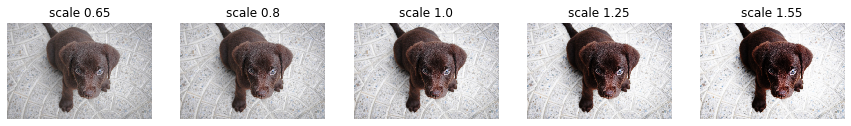

In [ ]:
scales = [0.65, 0.8, 1., 1.25, 1.55]
cont = Contrast(p=1., draw=scales)
y = cont(_batch_ex(5), filt=0)
fig,axs = plt.subplots(1,5, figsize=(15,3))
for i,ax in enumerate(axs.flatten()): show_image(y[i], ctx=ax, title=f'scale {scales[i]}')

In [ ]:
#hide
x = torch.randn(5, 3, 4, 4)
y = cont(TensorImage(x), filt=0)
y1 = torch.sigmoid(logit(x) * tensor(scales)[:,None,None,None])
test_close(y, y1)

test_eq(cont(TensorMask(x), filt=0), x)
test_eq(cont(TensorPoint(x), filt=0), x)
test_eq(cont(TensorBBox((x,x)), filt=0), (x,x))

## All together

In [ ]:
# export
def _compose_same_tfms(tfms):
    tfms = L(tfms)
    if len(tfms) == 0: return None
    res = tfms[0]
    for tfm in tfms[1:]: res.compose(tfm)
    return res

In [ ]:
# export
def setup_aug_tfms(tfms):
    "Go through `tfms` and combines together affine/coord or lighting transforms"
    aff_tfms = [tfm for tfm in tfms if isinstance(tfm, AffineCoordTfm)]
    lig_tfms = [tfm for tfm in tfms if isinstance(tfm, LightingTfm)]
    others = [tfm for tfm in tfms if tfm not in aff_tfms+lig_tfms]
    aff_tfm,lig_tfm =  _compose_same_tfms(aff_tfms),_compose_same_tfms(lig_tfms)
    res = [aff_tfm] if aff_tfm is not None else []
    if lig_tfm is not None: res.append(lig_tfm)
    return res + others

In [ ]:
#Affine only
tfms = [Rotate(draw=10., p=1), Zoom(draw=1.1, draw_x=0.5, draw_y=0.5, p=1.)]
comp = setup_aug_tfms([Rotate(draw=10., p=1), Zoom(draw=1.1, draw_x=0.5, draw_y=0.5, p=1.)])
test_eq(len(comp), 1)
x = torch.randn(4,3,5,5)
test_close(comp[0]._get_affine_mat(x),tfms[0]._get_affine_mat(x) @ tfms[1]._get_affine_mat(x))
#We can't test that the ouput of comp or the compostiionf of tfms on x is the same cause it's not (1 interpol vs 2 sp)

In [ ]:
#Affine + lighting
tfms = [Rotate(), Zoom(), Warp(), Brightness(), Flip(), Contrast()]
comp = setup_aug_tfms(tfms)
test_eq(len(comp), 2)
test_eq(len(comp[0].aff_fs), 3)
test_eq(len(comp[0].coord_fs), 1)
test_eq(len(comp[1].fs), 2)

In [ ]:
#Affine + lighting + others
tfms = [Rotate(), Zoom(), Warp(), Brightness(), Flip(), Contrast(), Cuda()]
comp = setup_aug_tfms(tfms)
test_eq(len(comp), 3)
test_eq(len(comp[0].aff_fs), 3)
test_eq(len(comp[0].coord_fs), 1)
test_eq(len(comp[1].fs), 2)

In [ ]:
# export
def aug_transforms(do_flip=True, flip_vert=False, max_rotate=10., max_zoom=1.1, max_lighting=0.2,
                   max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=None,
                   size=None, mode='bilinear', pad_mode=PadMode.Reflection):
    "Utility func to easily create a list of flip, rotate, zoom, warp, lighting transforms."
    res,tkw = [],dict(size=size, mode=mode, pad_mode=pad_mode)
    if do_flip:    res.append(Dihedral(p=0.5, **tkw) if flip_vert else Flip(p=0.5, **tkw))
    if max_warp:   res.append(Warp(magnitude=max_warp, p=p_affine, **tkw))
    if max_rotate: res.append(Rotate(max_deg=max_rotate, p=p_affine, **tkw))
    if max_zoom>1: res.append(Zoom(max_zoom=max_zoom, p=p_affine, **tkw))
    if max_lighting:
        res.append(Brightness(max_lighting=max_lighting, p=p_lighting))
        res.append(Contrast(max_lighting=max_lighting, p=p_lighting))
    return setup_aug_tfms(res + L(xtra_tfms))

Random flip (or dihedral if `flip_vert=True`) with `p=0.5` is added when `do_flip=True`. With `p_affine` we apply a random rotation of `max_rotate` degrees, a random zoom of `maz_zoom` and a perspective warping of `max_warp`. With `p_ligthing` we apply a change in brightness and contrast of `max_lighting`. Custon `xtra_tfms` can be added. `size`, `mode` and `pad_mode` will be used for the interpolation.

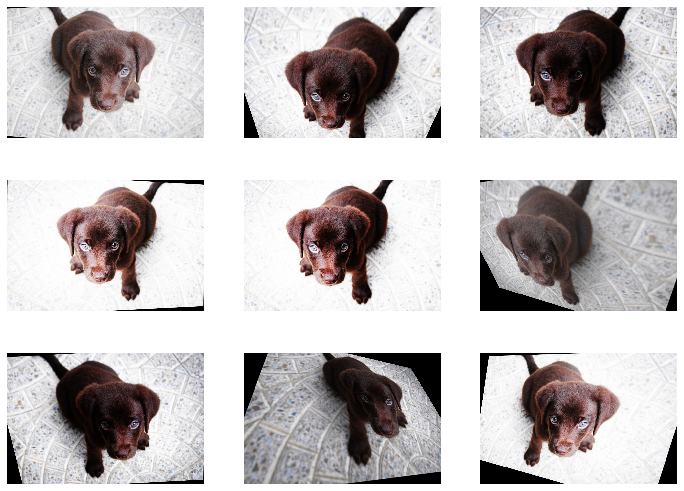

In [ ]:
tfms = aug_transforms(pad_mode='zeros', max_lighting=0.5, max_warp=0.4)
y = _batch_ex(9)
for t in tfms: y = t(y, filt=0)
_,axs = plt.subplots(3,3, figsize=(12,9))
for i,ax in enumerate(axs.flatten()): show_image(y[i], ctx=ax)

## Integration tests

### Segmentation

In [ ]:
camvid = untar_data(URLs.CAMVID_TINY)
fns = get_image_files(camvid)
cam_fn = fns[0]
mask_fn = camvid/'labels'/f'{cam_fn.stem}_P{cam_fn.suffix}'
def _cam_lbl(fn): return mask_fn

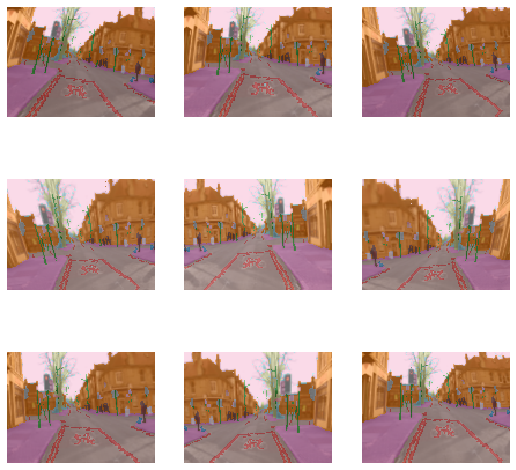

In [ ]:
cam_dsrc = DataSource([cam_fn]*10, [PILImage.create, [_cam_lbl, PILMask.create]])
cam_tdl = TfmdDL(cam_dsrc.train, after_item=ToTensor(), after_batch=[Cuda(), ByteToFloatTensor(), *aug_transforms()], bs=9)
_,axs = plt.subplots(3,3, figsize=(9,9))
cam_tdl.show_batch(ctxs=axs.flatten(), vmin=1, vmax=30)

### Point targets

In [ ]:
mnist = untar_data(URLs.MNIST_TINY)
fns = get_image_files(mnist)
mnist_fn = fns[0]
pnts = np.array([[0,0], [0,35], [28,0], [28,35], [9, 17]])
# def _pnt_open(fn): return PILImage.create(fn).resize((28,35))
def _pnt_lbl(fn)->None: return TensorPoint.create(pnts)

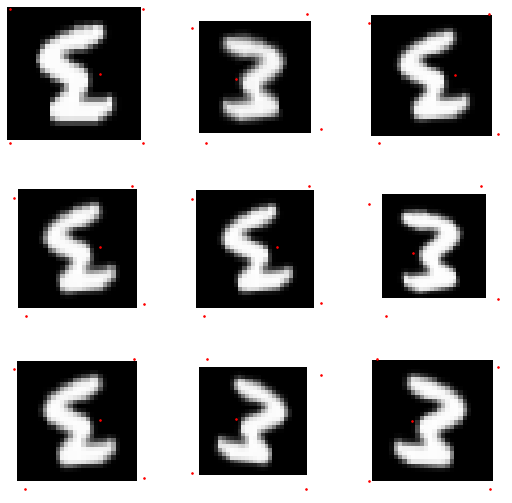

In [ ]:
pnt_dsrc = DataSource([mnist_fn]*10, [[PILImage.create, Resize((35,28))], _pnt_lbl])
pnt_tdl = TfmdDL(pnt_dsrc.train, after_item=[PointScaler(), Resize(28), ToTensor()],
                 after_batch=[Cuda(), ByteToFloatTensor(), *aug_transforms(max_warp=0)], bs=9)
_,axs = plt.subplots(3,3, figsize=(9,9))
pnt_tdl.show_batch(ctxs=axs.flatten())

### Bounding boxes

In [ ]:
coco = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco/'train.json')
idx=2
coco_fn,bbox = coco/'train'/images[idx],lbl_bbox[idx]
def _coco_lbl(fn)->None: return BBox(bbox)

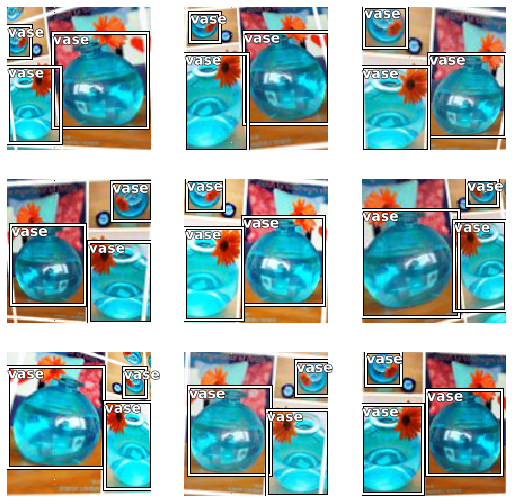

In [ ]:
coco_dsrc = DataSource([coco_fn]*10, [PILImage.create, [_coco_lbl, BBoxCategorize()]])
coco_tdl = TfmdDL(coco_dsrc.train, after_item=[BBoxScaler(), ToTensor()],
                  after_batch=[Cuda(), ByteToFloatTensor(), *aug_transforms()], bs=9)
_,axs = plt.subplots(3,3, figsize=(9,9))
coco_tdl.show_batch(ctxs=axs.flatten())

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_dataloader.ipynb.
Converted 01a_script.ipynb.
Converted 02_data_transforms.ipynb.
Converted 03_data_pipeline.ipynb.
Converted 04_data_external.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_source.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 11_layers.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 15_callback_hook.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_metrics.ipynb.
Converted 21_tutorial_imagenette.ipynb.
Converted 30_text_core.ipynb.
Converted 31_text_data.ipynb.
Converted 32_text_models_awdlstm.ipynb.
Converted 33_test_models_core.ipynb.
Converted 34_callback_rnn.ipynb.
Converted 35_tutorial_wikitext.ipynb.
Converted 36_text_models_qrnn.ipynb.
Converted